# Assignment03 12132191 陈鹏翰

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%config Completer.use_jedi = False
%matplotlib inline

In [3]:
plt.rcParams['figure.dpi'] = 300

# 1.Nino 3.4 index

## 1.1  Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

In [4]:
# loading the data
ds_sst=xr.open_dataset('data/NOAA_NCDC_ERSST_v3b_SST.nc')

# selecting nino3.4 region data
ds_sst_region=ds_sst.sel(lat=slice(-5,5),lon=slice(190,240))

# compute the 12 months sst
ds_sst_region_12months=ds_sst_region['sst'].groupby('time.month').mean(skipna=False)

In [5]:
# using numpy ndarray to compute
arr_region=ds_sst_region['sst'].values
arr_region_months=ds_sst_region_12months.values

# computing the anomalies
arr_anomalies=arr_region.copy()
for i in range(arr_region.shape[0]//arr_region_months.shape[0]):
    arr_anomalies[i*12:i*12+12,:,:]-=arr_region_months

#apply new anomalies to the dataset
ds_sst_region['sst'].values=arr_anomalies

Text(0.5, 1.0, 'monthly SST anomalies of nino3.4 region')

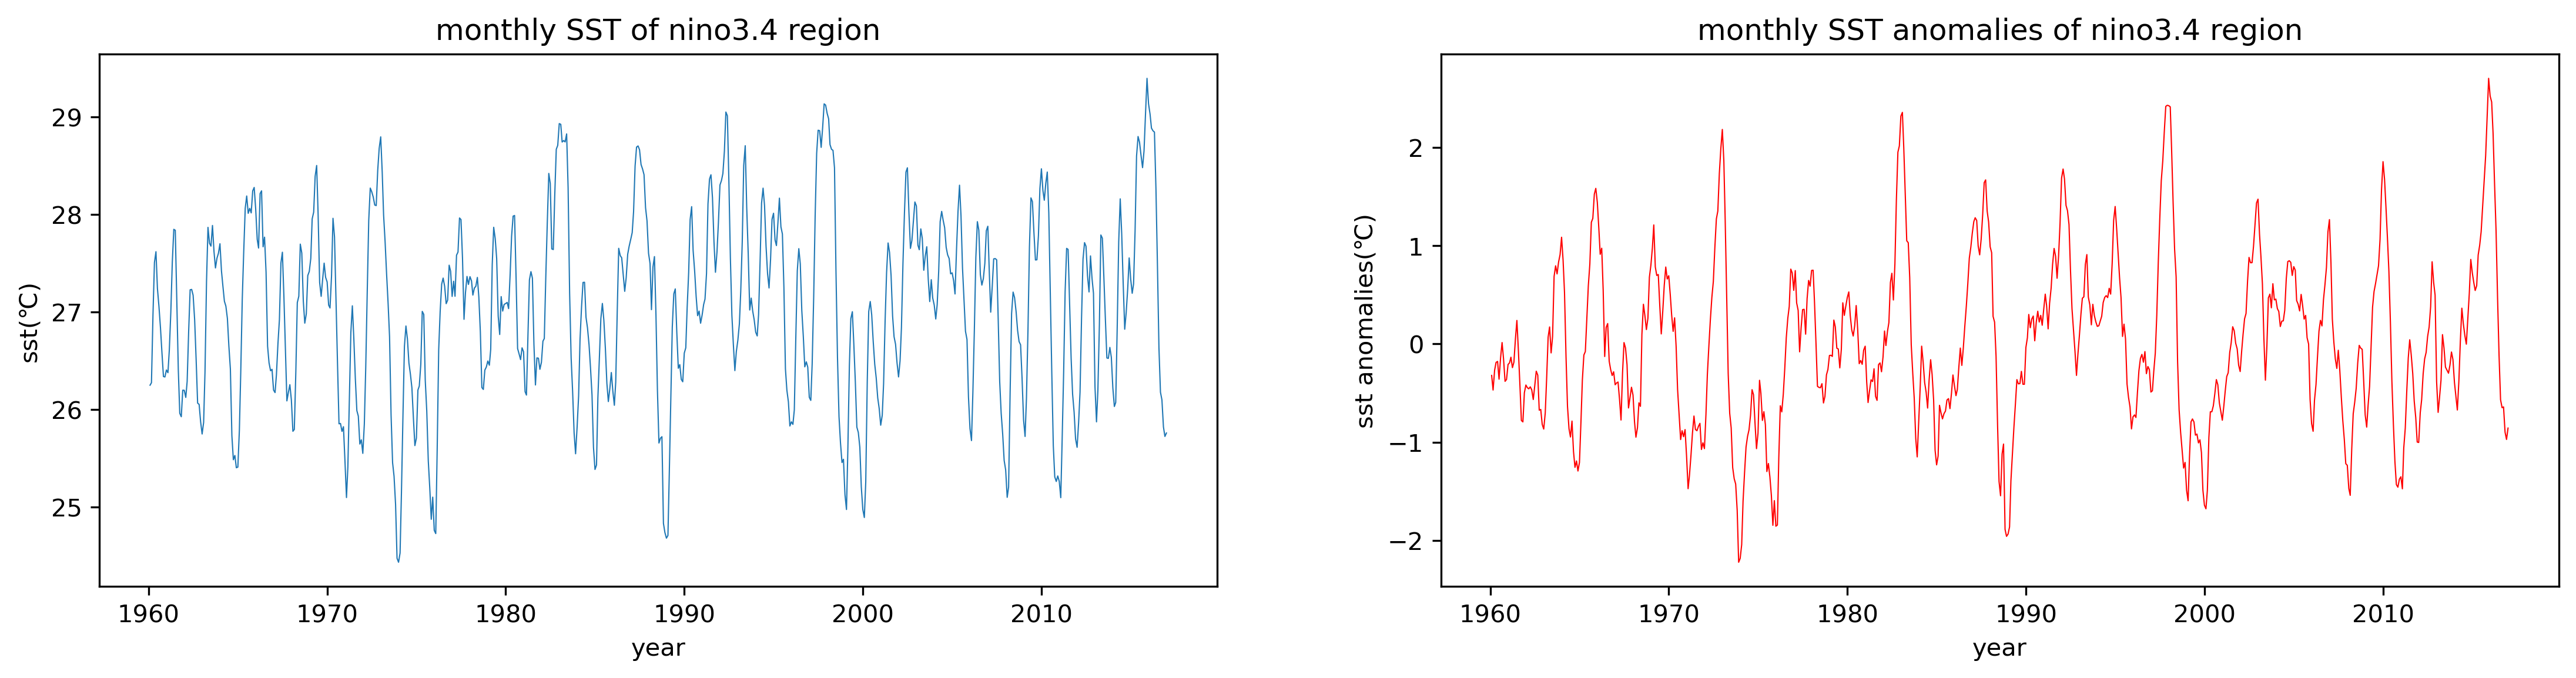

In [6]:
#plot 
time=pd.date_range(start='1960-01',periods=684,freq='m')
original=np.nanmean(arr_region,axis=(1,2))
anomalies=np.nanmean(arr_anomalies,axis=(1,2))
fig,axs =plt.subplots(1,2,figsize=(18,4))
axs[0].plot(time,original,lw=0.5)
axs[0].set_ylabel('sst(℃)')
axs[0].set_title('monthly SST of nino3.4 region')      
axs[0].set_xlabel('year')
axs[1].plot(time,anomalies,lw=0.5,c='r')
axs[1].set_xlabel('year')
axs[1].set_ylabel('sst anomalies(℃)')
axs[1].set_title('monthly SST anomalies of nino3.4 region')

## 1.2 Visualize the computed Niño 3.4.

Text(0.5, 1.0, 'SST Anomaly in Nino 3.4 Region(5N-5S,120-170W)')

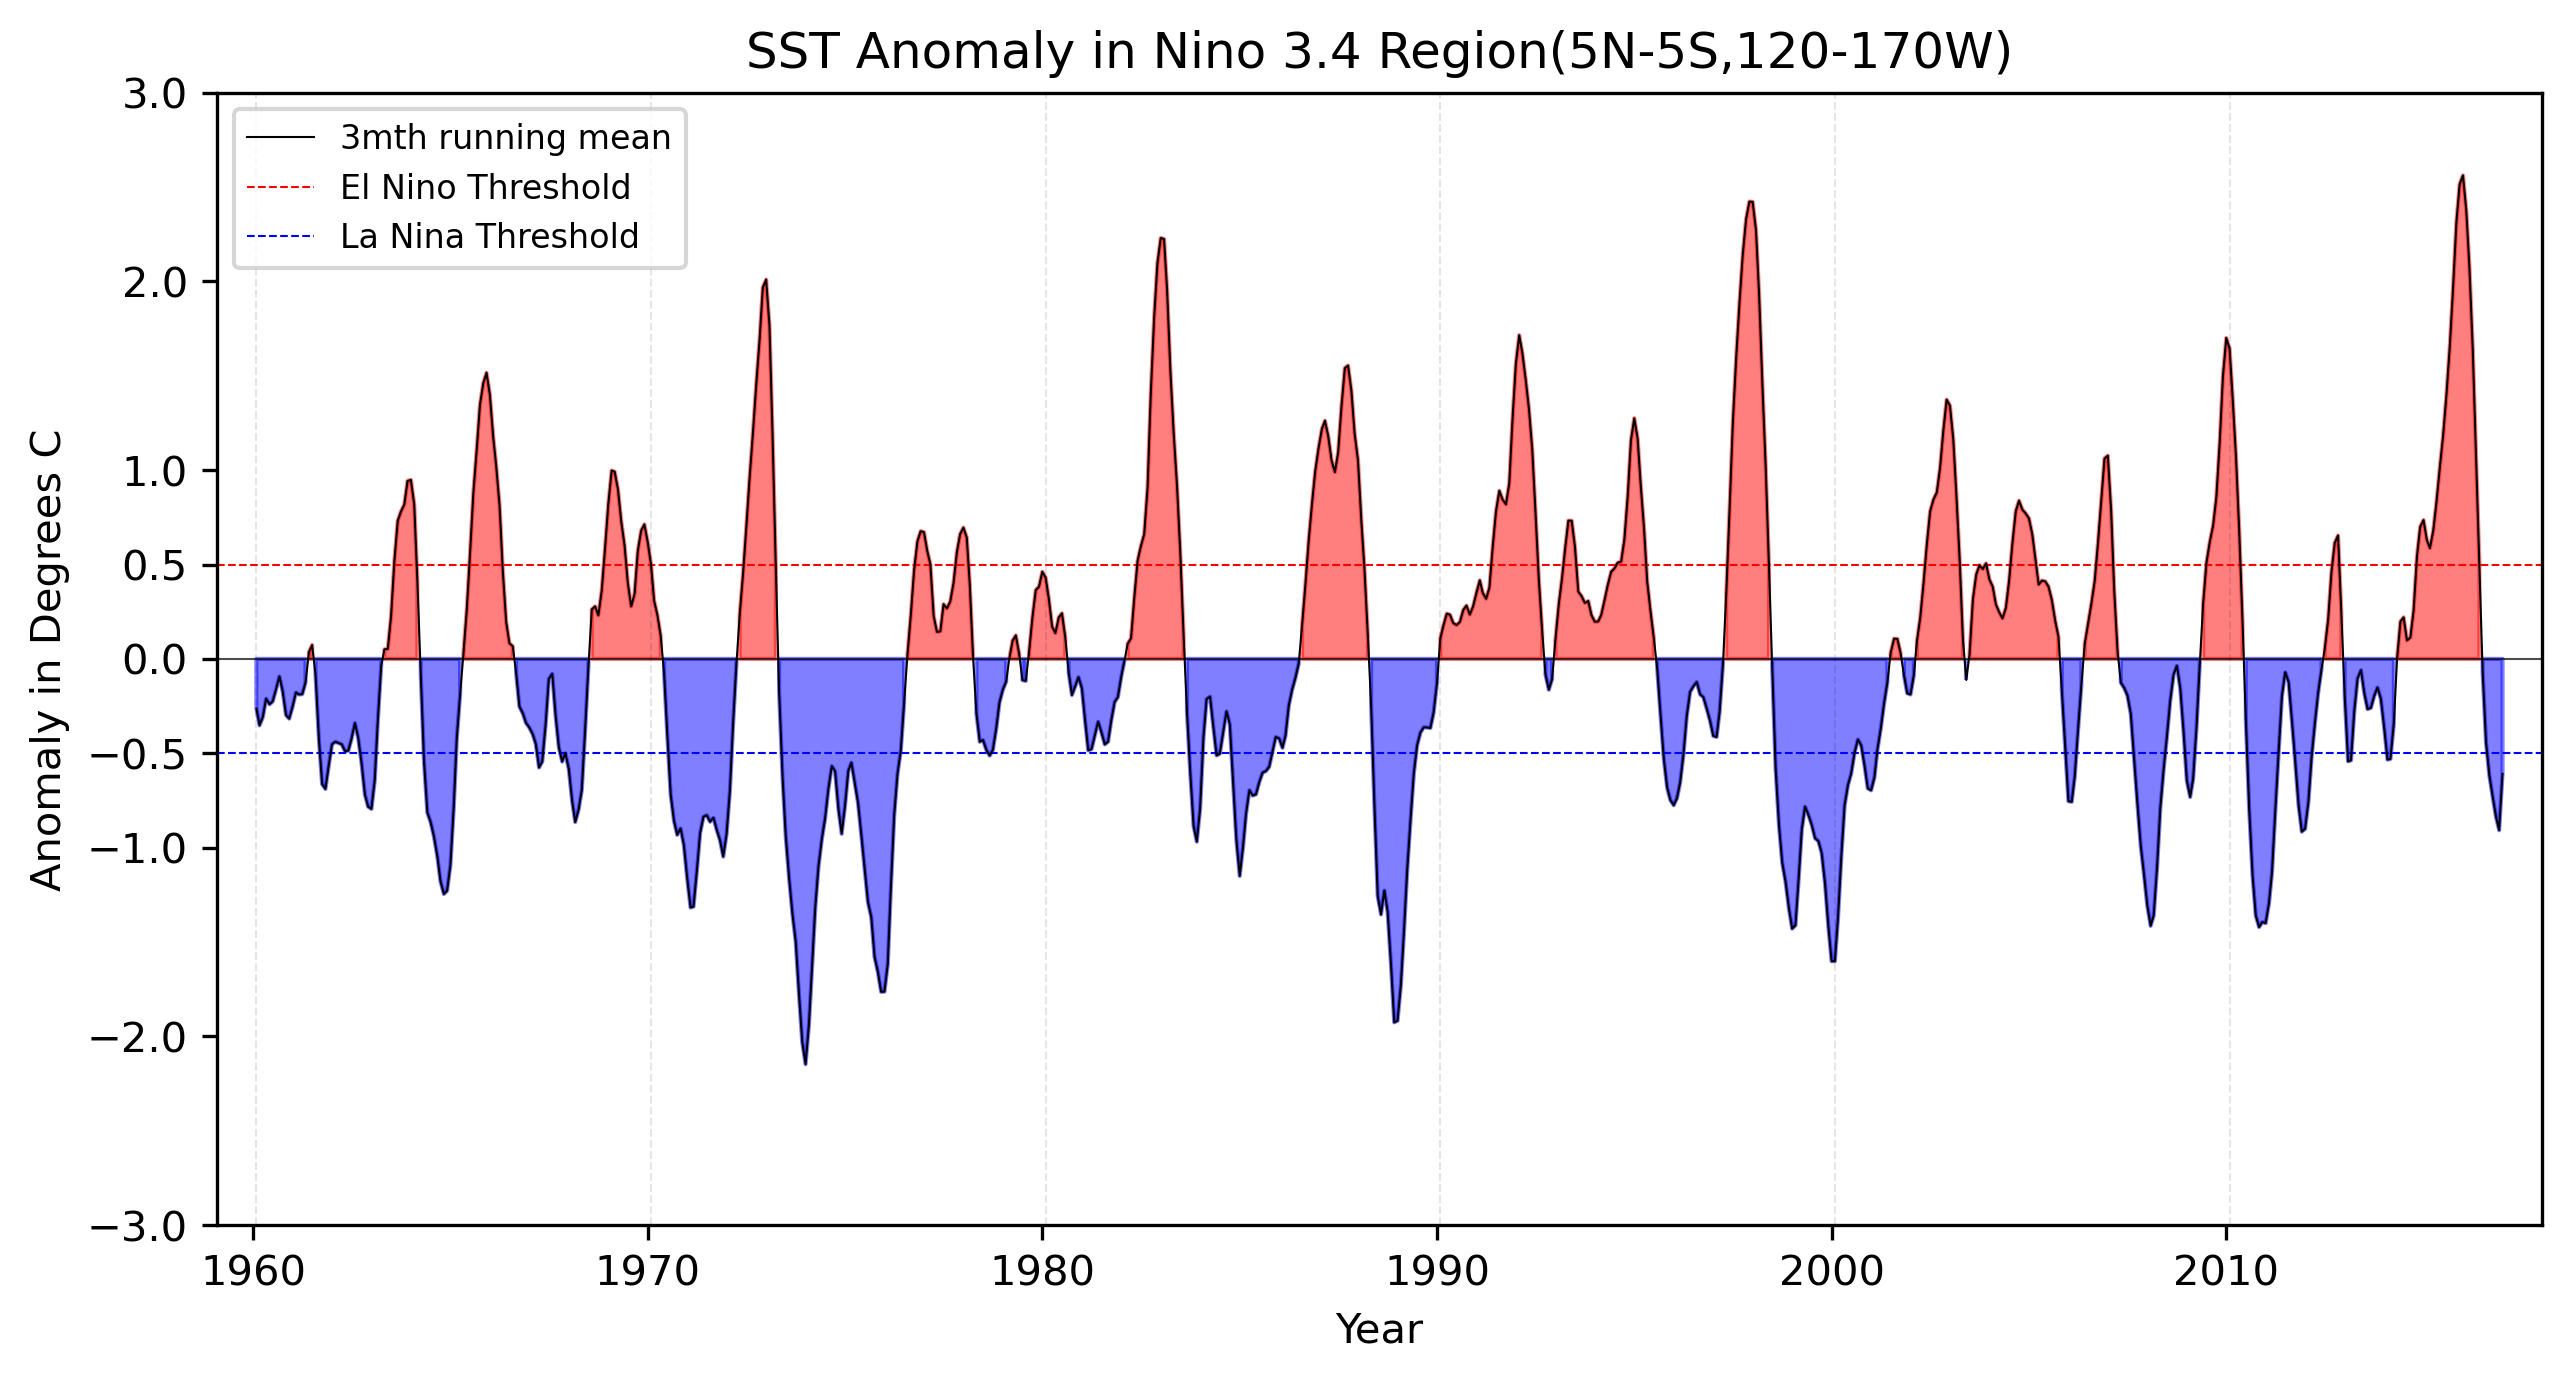

In [7]:
# computing the running mean(rolling window mean)
running_mean=np.convolve(anomalies,np.ones((3,))/3,mode='same')

# plot
time=pd.date_range(start='1960-01',periods=684,freq='m')
time_bound=pd.date_range(start='1959-01',periods=684+24,freq='m')

fig,ax =plt.subplots(1,1,sharex=True,figsize=(10,5))

ax.plot(time,running_mean,lw=0.5,c='k',label='3mth running mean')

ax.hlines(y=0.5,xmin=time_bound[0],xmax=time_bound[-1],ls='--',lw=0.5,colors='r',label='El Nino Threshold')
ax.hlines(y=-0.5,xmin=time_bound[0],xmax=time_bound[-1],ls='--',lw=0.5,colors='b',label='La Nina Threshold')
ax.hlines(y=0,xmin=time_bound[0],xmax=time_bound[-1],ls='-',lw=0.5,colors='k',alpha=0.7)
for i in range(0,len(time),120):
    ax.vlines(x=time[i],ymin=-3,ymax=3,ls='--',lw=0.5,colors='k',alpha=0.1)

ax.set_xlim(time_bound[0],time_bound[-1])
ax.set_ylim(-3,3)
ax.set_yticks([-3,-2,-1,-0.5,0,0.5,1,2,3])
ax.fill_between(time,y1=(running_mean),y2=0,where=(running_mean>0),color='r',alpha=0.5)
ax.fill_between(time,y1=(running_mean),y2=0,where=(running_mean<0),color='b',alpha=0.5)

ax.legend(loc=2,fontsize=8)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly in Degrees C')
ax.set_title('SST Anomaly in Nino 3.4 Region(5N-5S,120-170W)')   

# 2. Earth’s energy budget

## 2.1 Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

In [8]:
ds_toa=xr.open_dataset('data/CERES_EBAF-TOA_200003-201701.nc')
da_lw=ds_toa['toa_lw_all_mon']
da_sw=ds_toa['toa_sw_all_mon']
da_sr=ds_toa['solar_mon']
da_nf=ds_toa['toa_net_all_mon']
time=ds_toa['time']

Text(0.5, 1.0, 'net flux')

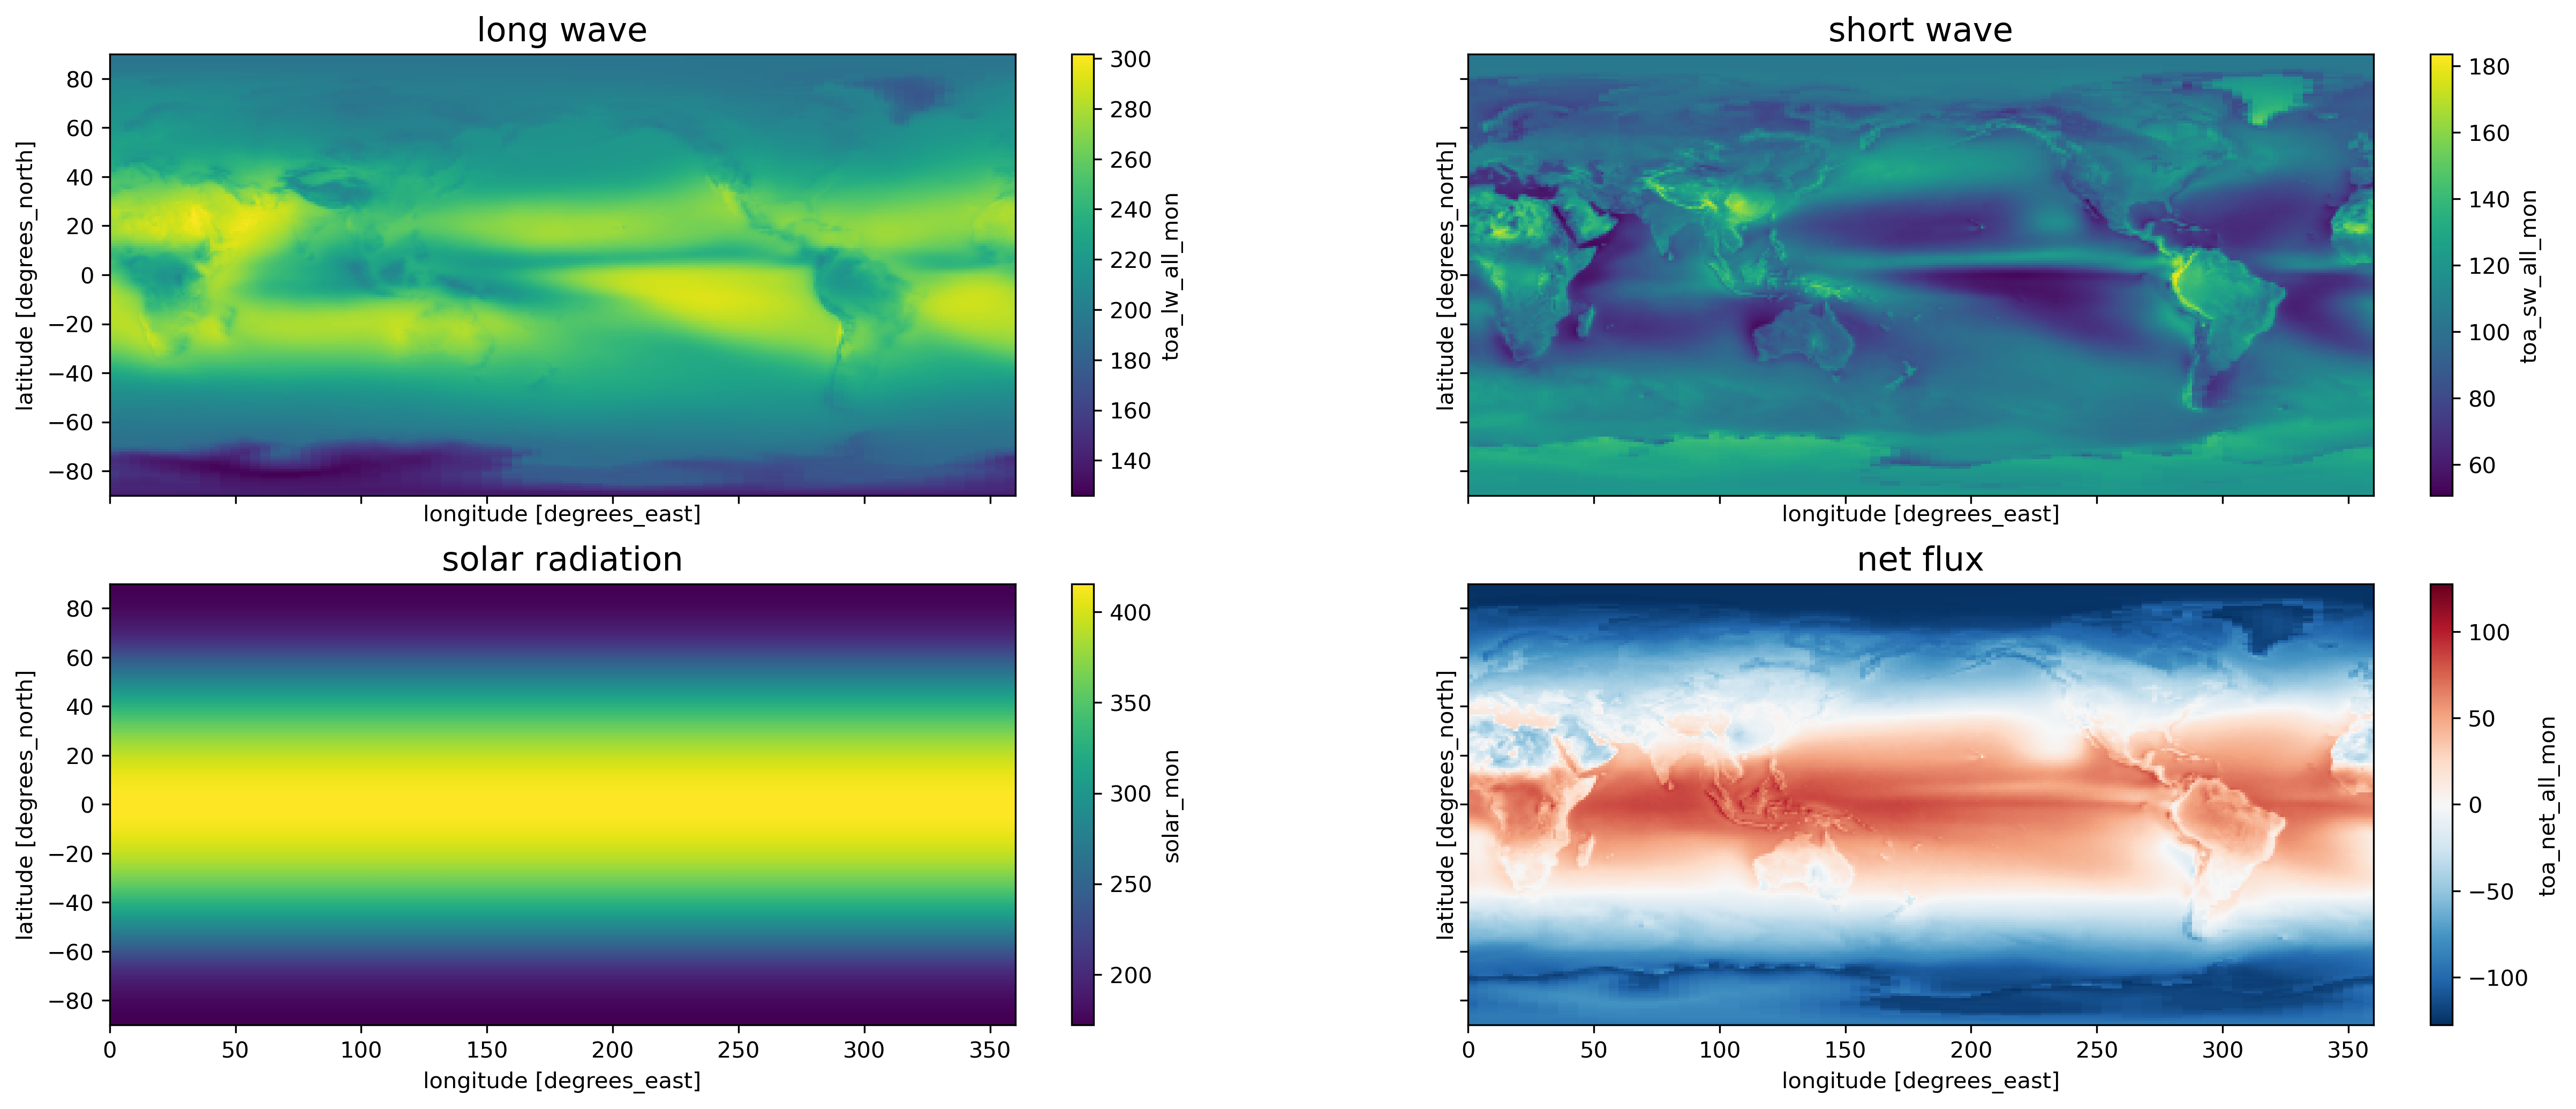

In [9]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,8))
da_lw.mean(dim='time').plot(ax=axs[0,0])
da_sw.mean(dim='time').plot(ax=axs[0,1])
da_sr.mean(dim='time').plot(ax=axs[1,0])
da_nf.mean(dim='time').plot(ax=axs[1,1])

axs[0,0].set_title('long wave',fontsize=15)
axs[0,1].set_title('short wave',fontsize=15)
axs[1,0].set_title('solar radiation',fontsize=15)
axs[1,1].set_title('net flux',fontsize=15)

Text(0.5, 1.0, 'diff = long wave + short wave + net flux - solar radiation')

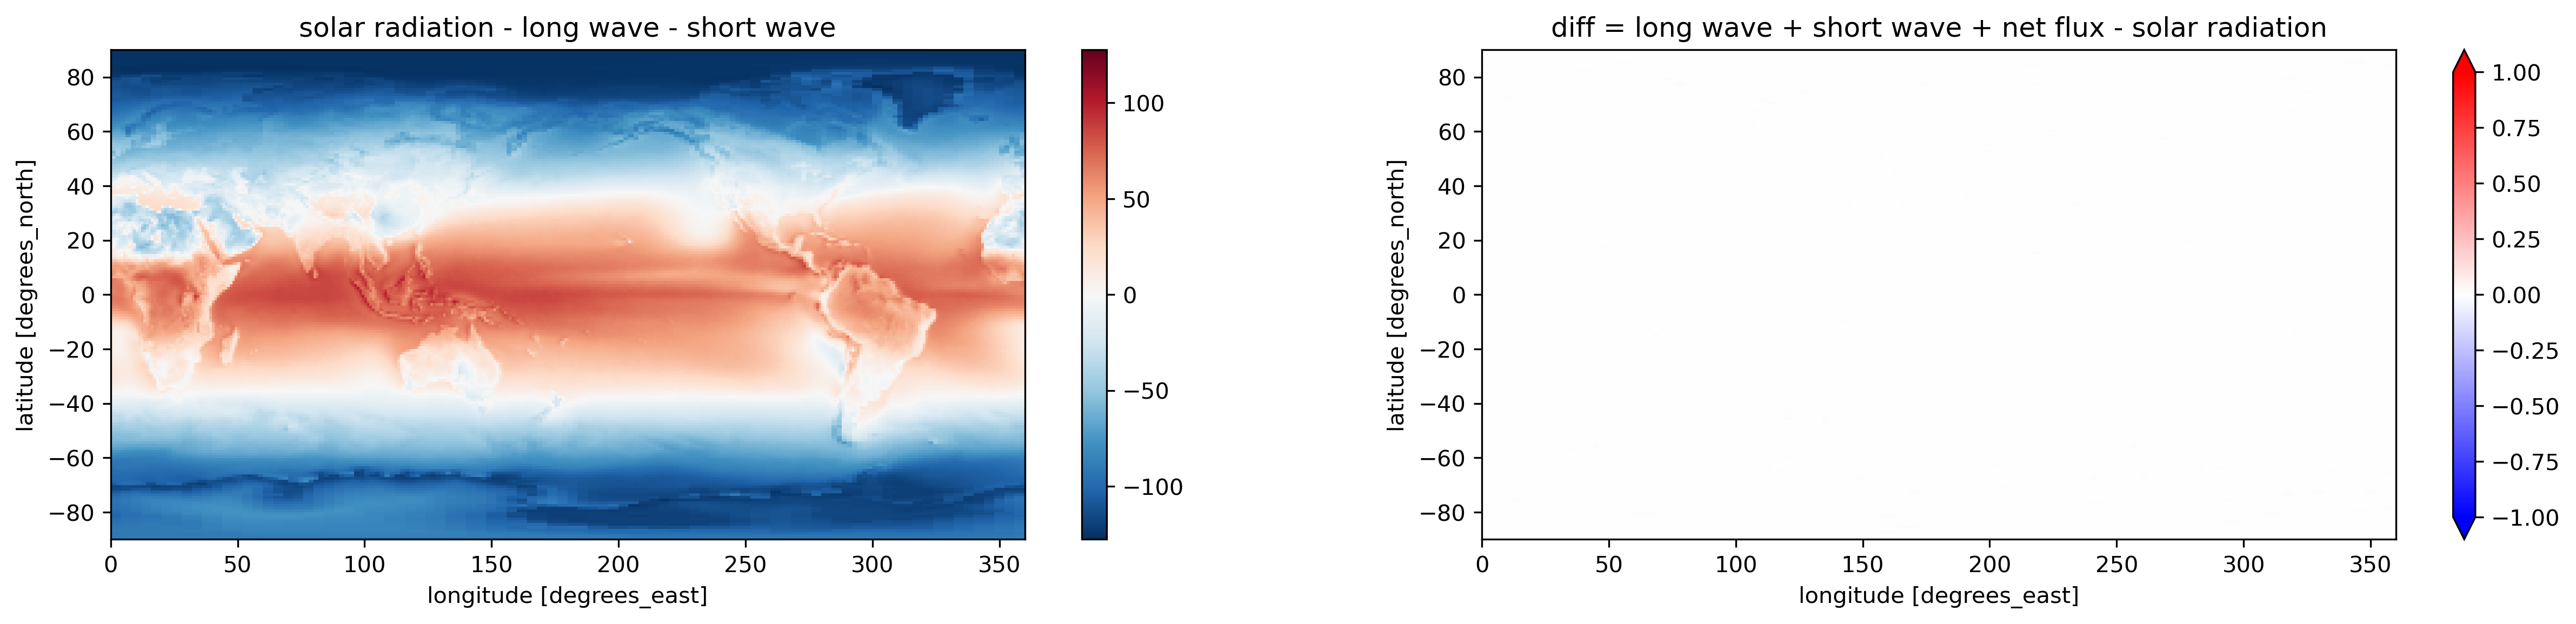

In [10]:
fig,axs=plt.subplots(1,2,figsize=(20,4))
(da_sr-da_lw-da_sw).mean(dim='time').plot(ax=axs[0])
(da_sr-da_lw-da_sw-da_nf).mean(dim='time').plot(ax=axs[1],vmax=-1,vmin=1,cmap='bwr')
axs[0].set_title('solar radiation - long wave - short wave')
axs[1].set_title('diff = long wave + short wave + net flux - solar radiation')

### As we can see from the figs above, $ diff = 0$   ,so:
### $E_{SolarRadiation}-E_{Longwave}-E_{Shortwave}=E_{NetFlux}$

## 2.2 Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.

In [11]:
ds_toa=xr.open_dataset('data/CERES_EBAF-TOA_200003-201701.nc')
da_lw=ds_toa['toa_lw_all_mon']
da_sw=ds_toa['toa_sw_all_mon']
da_sr=ds_toa['solar_mon']
da_nf=ds_toa['toa_net_all_mon']

# I  draw a globe to find that: $S_{ij}=\frac{2{\pi}^2 R^2cosj}{N_iN_j}$
### where $S_{ij}$ means the area of the grid, $i$ means longitude, $j$ means latitude
### $N_i,N_j$ means the numbers of the grids at the dimension, $R$ is the radius of the glob, for the earth $R=6371.4km$

In [12]:
# calculate the area of each grid aproximately

R=6371.4e3

lat_j=np.linspace(-89.5,89.5,180)
lat_j_rad=np.deg2rad(lat_j)

cos_j=np.cos(lat_j_rad)
Sj=2*np.pi**2*cos_j*R**2/(180*360)

Sij=np.repeat(Sj.reshape(-1,1),360,axis=1)
Stij=np.repeat(Sij.reshape(1,180,360),203,axis=0)

In [13]:
da_sr.values*=Stij
da_lw.values*=Stij
da_sw.values*=Stij

In [14]:
# the area of the whole surface of earth
area_glob=4*np.pi*R**2

sr=da_sr.mean(dim='time').values.sum()/area_glob
lw=da_lw.mean(dim='time').values.sum()/area_glob
sw=da_sw.mean(dim='time').values.sum()/area_glob

In [15]:
print('solar radiations (Wm-2):',sr.round(1))
print('long wave outgoing (Wm-2):',lw.round(1))
print('short wave outgoing (Wm-2):',sw.round(1))

solar radiations (Wm-2): 340.3
long wave outgoing (Wm-2): 240.3
short wave outgoing (Wm-2): 99.1


# The 3 variables above [340.3,   240.3,   99.1] match the cartoons [340.4,  239.9,  99.9]

## 2.3  Calculate and plot the total amount of net radiation in each 1-degree latitude band. Label with correct units.

In [16]:
ds_toa=xr.open_dataset('data/CERES_EBAF-TOA_200003-201701.nc')
da_nf=ds_toa['toa_net_all_mon']

In [17]:
# convert net flux unit to GW(10^9W)
da_nf.values*=Stij/1e9

Text(0.5, 1.0, 'Net radiation in each 1-degree latitude band $(10^9W)$')

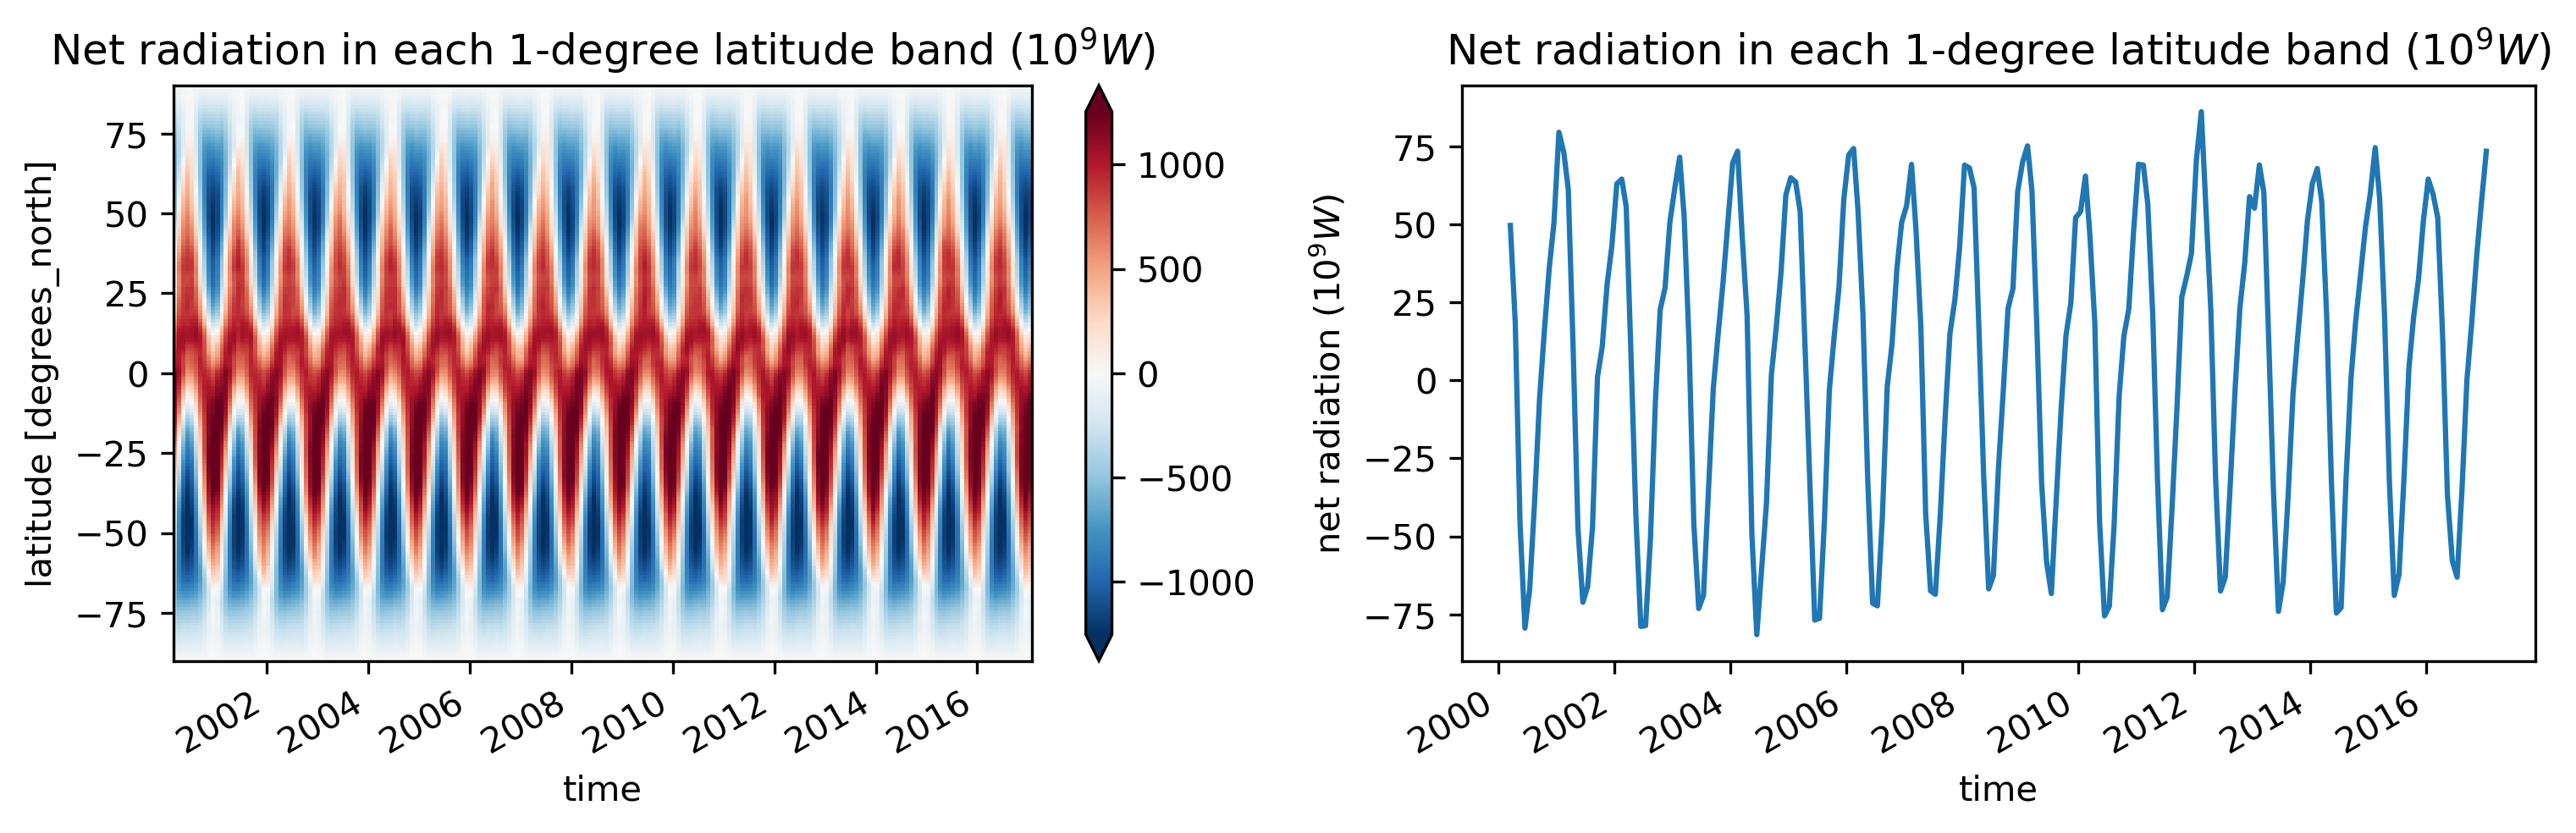

In [18]:
fig,axs=plt.subplots(1,2,figsize=(12,3),dpi=300)

da_nf.rename('').mean(dim='lon').transpose().plot(ax=axs[0],robust=True)
axs[0].set_title('Net radiation in each 1-degree latitude band $(10^9W)$')
da_nf.mean(dim={'lon','lat'}).plot(ax=axs[1])
axs[1].set_ylabel('net radiation $(10^9W)$')
axs[1].set_title('Net radiation in each 1-degree latitude band $(10^9W)$')

## 2.4 Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions. Here we define low cloud area as ≤25% and high cloud area as ≥75%. Your results should be 2D maps.

In [19]:
ds_toa=xr.open_dataset('data/CERES_EBAF-TOA_200003-201701.nc')
da_cf=ds_toa['cldarea_total_daynight_mon']
da_lw=ds_toa['toa_lw_all_mon']
da_sw=ds_toa['toa_sw_all_mon']

In [20]:
arr_cf=da_cf.mean(dim='time').values
mask_high=(arr_cf>=75)
mask_low=(arr_cf<=25)

In [21]:
arr_hc_lw=da_lw.mean(dim='time').values
arr_hc_lw[~mask_high]=np.nan
arr_hc_sw=da_sw.mean(dim='time').values
arr_hc_sw[~mask_high]=np.nan
arr_lc_lw=da_lw.mean(dim='time').values
arr_lc_lw[~mask_low]=np.nan
arr_lc_sw=da_sw.mean(dim='time').values
arr_lc_sw[~mask_low]=np.nan

In [22]:
lat=ds_toa['lat']
lon=ds_toa['lon']

In [23]:
da_hc_lw=xr.DataArray(arr_hc_lw, coords=[lat, lon], dims=["lat", "lon"])
da_hc_sw=xr.DataArray(arr_hc_sw, coords=[lat, lon], dims=["lat", "lon"])
da_lc_lw=xr.DataArray(arr_lc_lw, coords=[lat, lon], dims=["lat", "lon"])
da_lc_sw=xr.DataArray(arr_lc_sw, coords=[lat, lon], dims=["lat", "lon"])

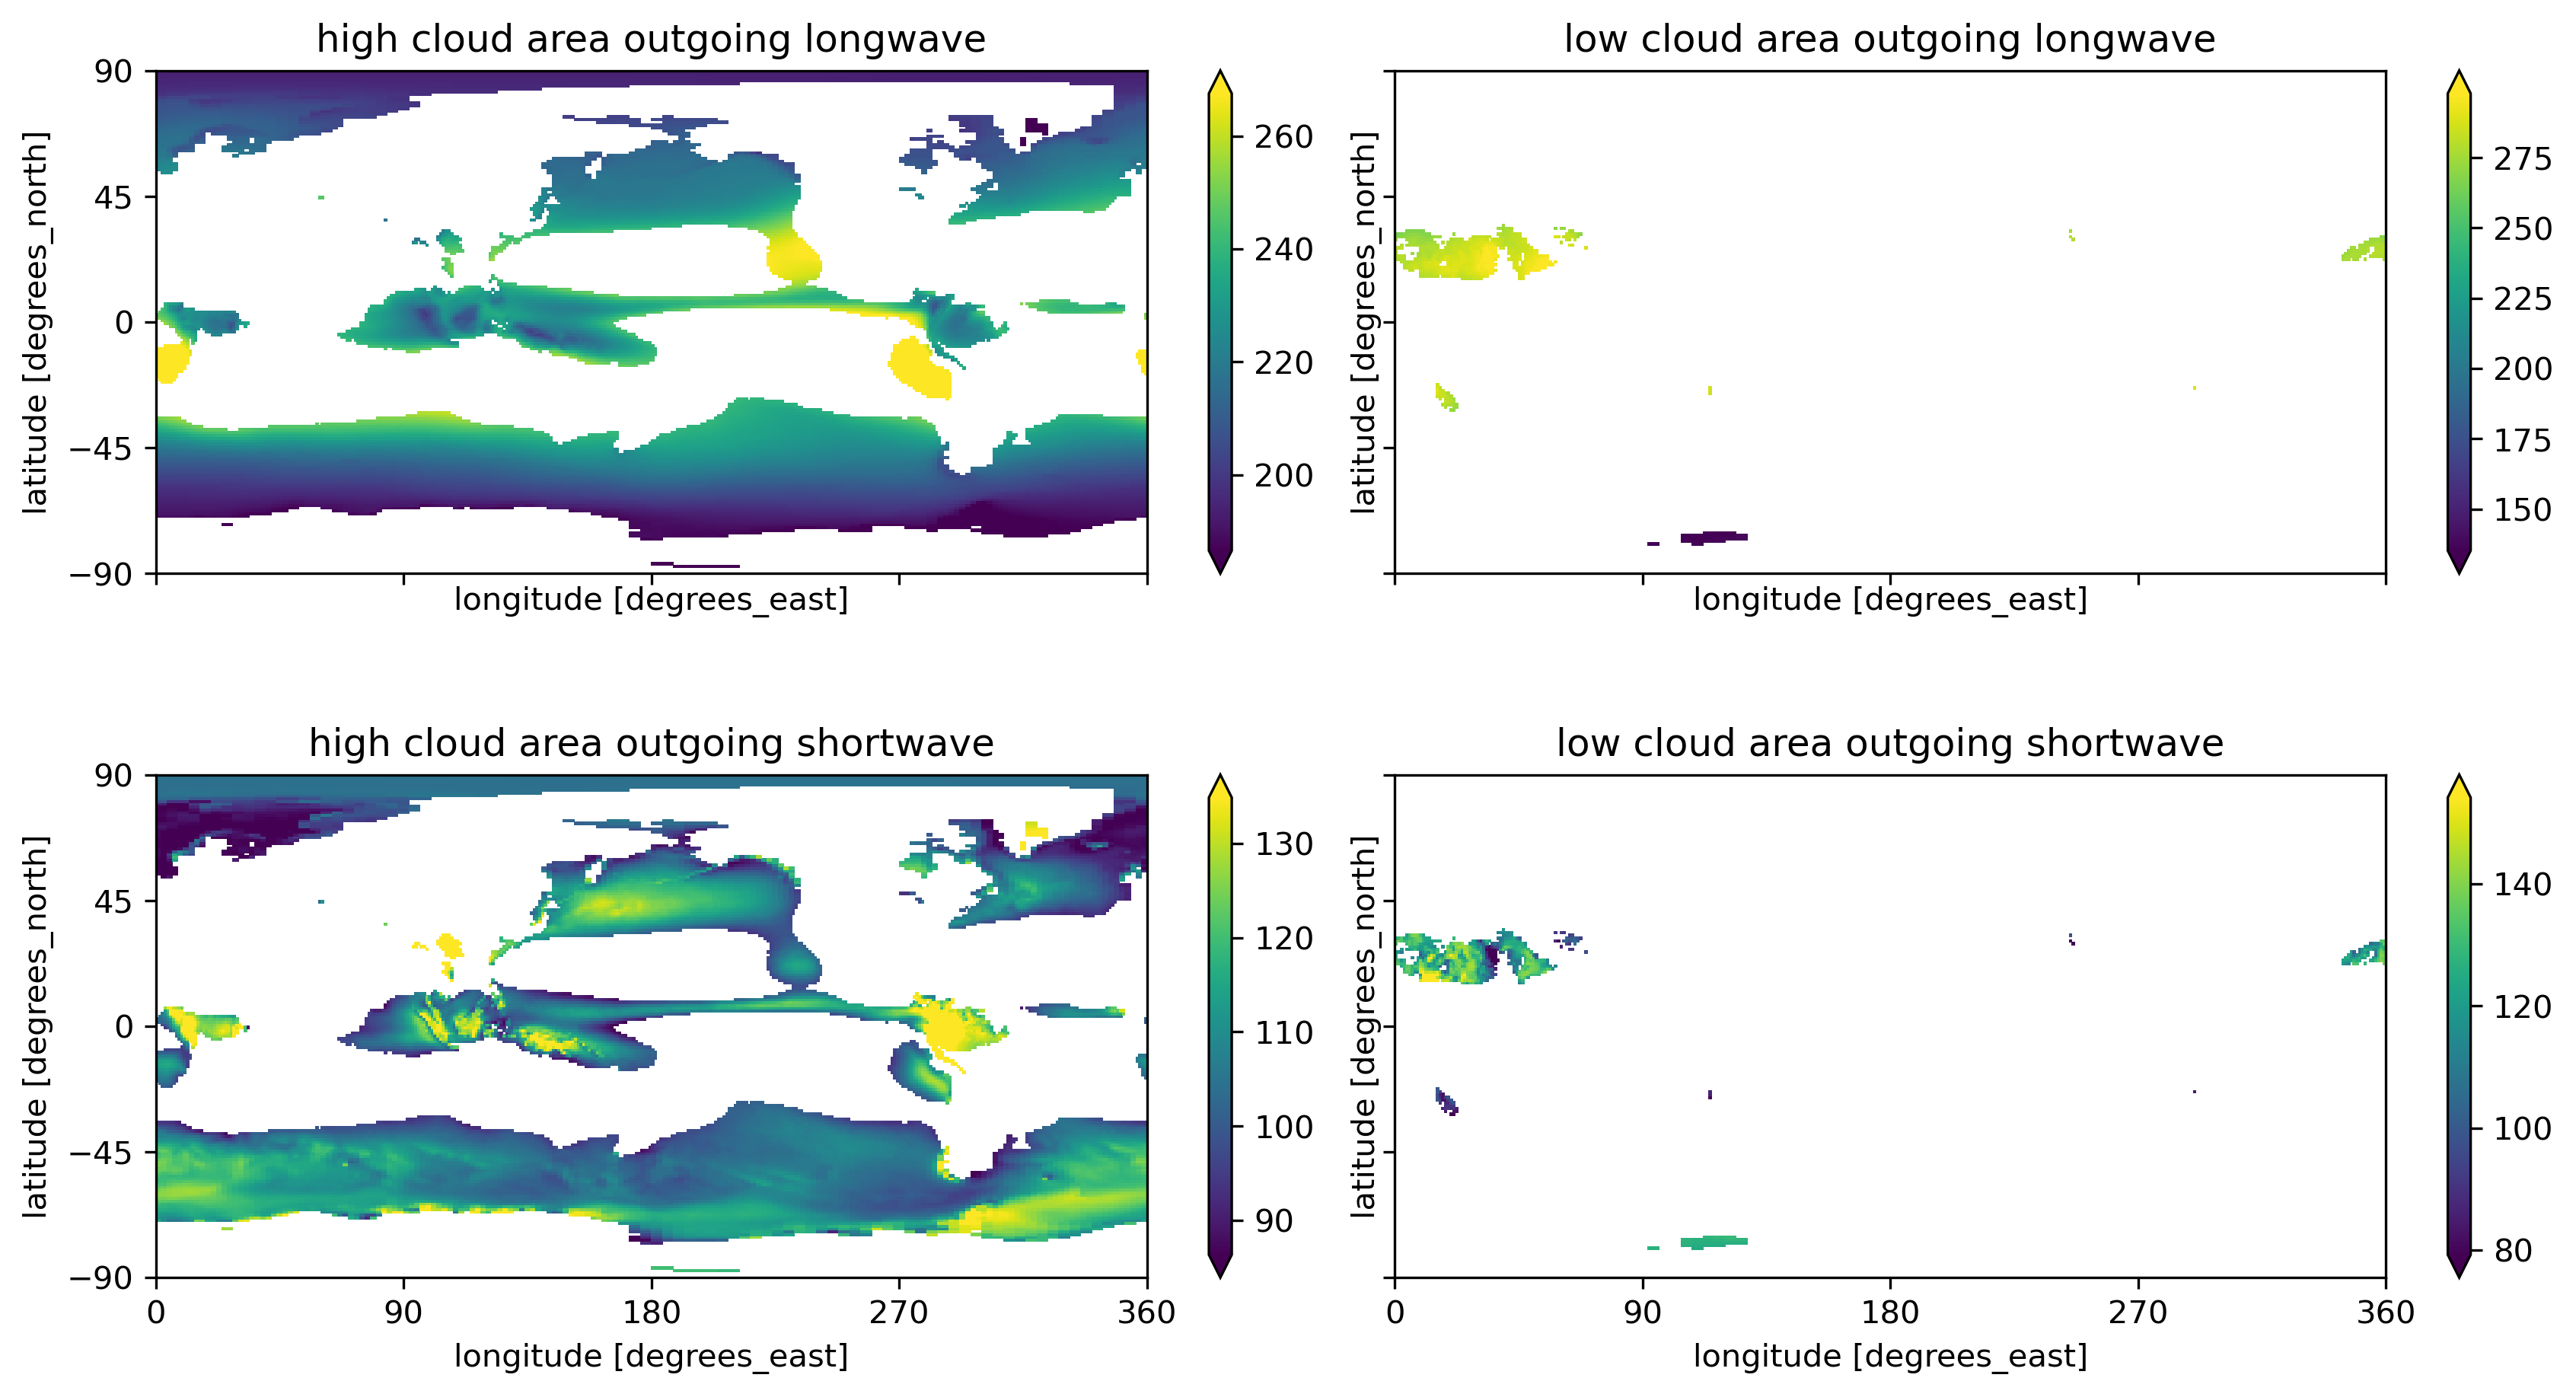

In [24]:
fig,axs=plt.subplots(2,2,figsize=(14,7),sharex=True,sharey=True,dpi=300)
da_hc_lw.plot(ax=axs[0,0],robust=True)
da_hc_sw.plot(ax=axs[1,0],robust=True)
da_lc_lw.plot(ax=axs[0,1],robust=True)
da_lc_sw.plot(ax=axs[1,1],robust=True)
axs[0,0].set_title('high cloud area outgoing longwave')
axs[0,0].set_xticks([0,90,180,270,360])
axs[0,0].set_yticks([-90,-45,0,45,90])
axs[1,0].set_title('high cloud area outgoing shortwave')
axs[0,1].set_title('low cloud area outgoing longwave')
axs[1,1].set_title('low cloud area outgoing shortwave')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.4)

## 2.5 Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions. What is the overall effect of clouds on shortwave and longwave radiation?

In [25]:
print('high cloud, long wave:',np.nanmean(arr_hc_lw))
print('high cloud, short wave:',np.nanmean(arr_hc_sw))
print('low cloud, long wave:',np.nanmean(arr_lc_lw))
print('low cloud, short wave:',np.nanmean(arr_lc_sw))

high cloud, long wave: 216.55675
high cloud, short wave: 108.09777
low cloud, long wave: 270.10367
low cloud, short wave: 122.65546


### We can find from the result above: Clouds can $\color{red}{increase}$ the shortwave and longwave radiation

# 3. Explore a ```netCDF``` dataset

### Browse the NASA’s Goddard Earth Sciences Data and Information Services Center (GES DISC) website. Search and download a dataset you are interested in. You are also welcome to use data from your group in this problem set. But the dataset should be in netCDF format, and have temporal information.

## 3.1 Plot a time series of a certain variable with monthly seasonal cycle removed.

In [26]:
ds_wind=xr.open_dataset('CMFD_wind.nc')

In [27]:
group_data = ds_wind.wind.groupby('time.month')
da_anom_wind=group_data-ds_wind['wind'].groupby('time.month').mean(skipna=False)

Text(0.5, 1.0, "China's Wind Speed Anomalies 2000-2018")

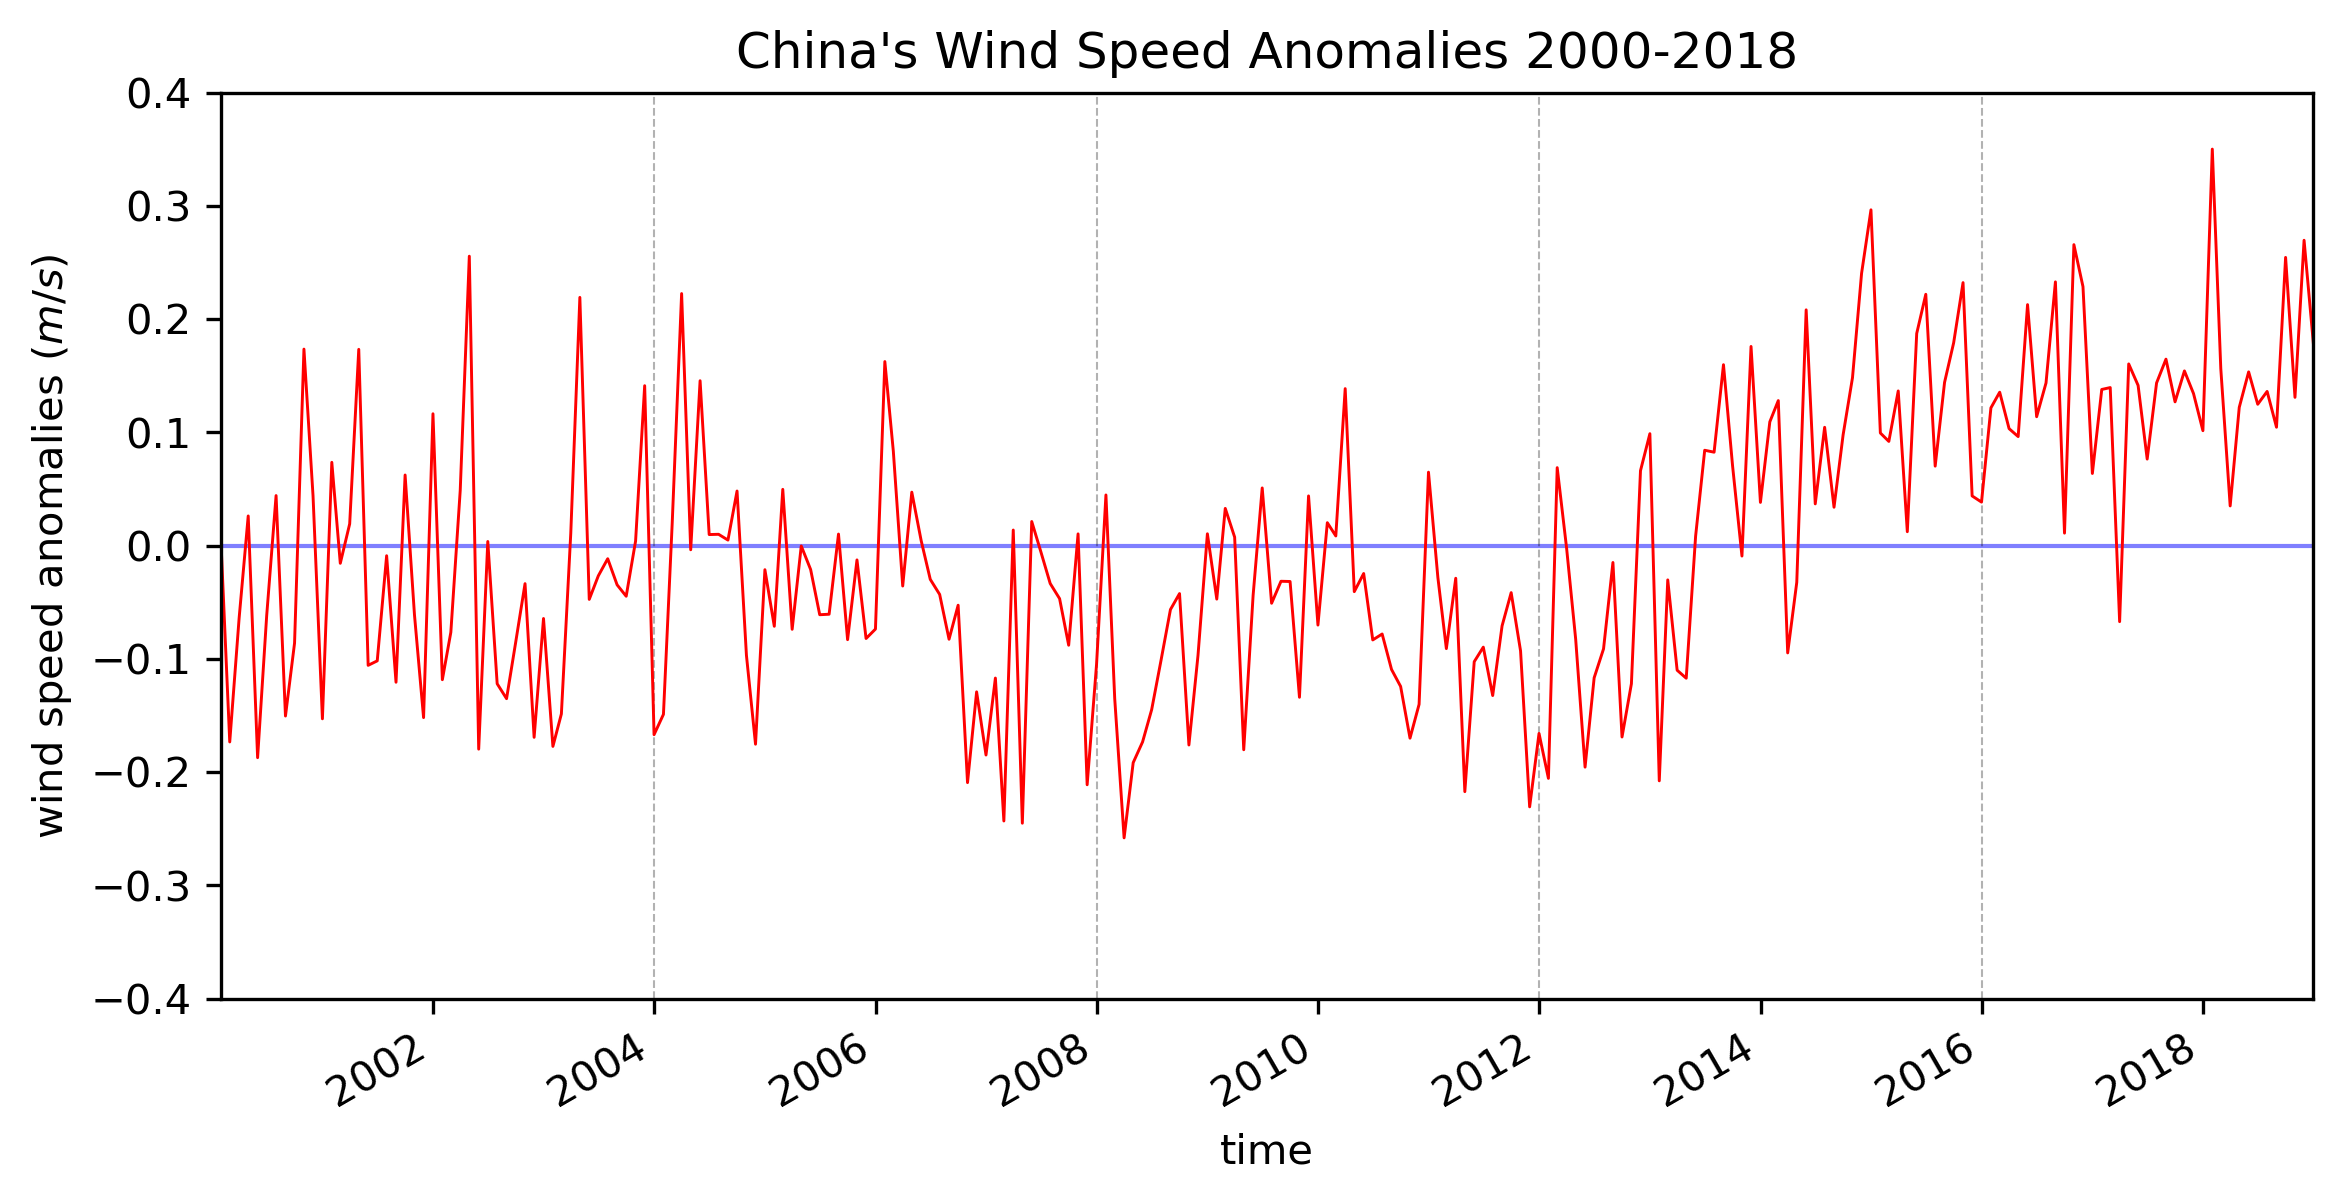

In [34]:
fig,ax=plt.subplots(1,1,figsize=(9,4))
data=da_anom_wind.mean(dim={'lon','lat'})
data.plot(ax=ax,c='r',lw=0.7)
ax.set_xlim(data.time.values[0],data.time.values[-1])
ax.set_ylim((-0.4,0.4))
ax.hlines(0,data.time.values[0],data.time.values[-1],colors='b',ls='-',lw=1,alpha=0.5)
for i in range(48,228,48):
    ax.vlines(data.time.values[i-1],-0.4,0.4,colors='k',ls='--',lw=0.5,alpha=0.3)

ax.set_ylabel('wind speed anomalies $(m/s)$')
ax.set_title('China\'s Wind Speed Anomalies 2000-2018')

## 3.2 Make at least 5 different plots using the dataset.

In [35]:
arr_wind=ds_wind['wind'].values
lat=ds_wind['lat'].values
lon=ds_wind['lon'].values

In [36]:
windle2=np.full((400,700),np.nan)
windle4=np.full((400,700),np.nan)
for i in range(400):
    for j in range(700):
        if not all(np.isnan(arr_wind[:,i,j])):
            windle2[i,j]=(arr_wind[:,i,j]>=2).sum()
            windle4[i,j]=(arr_wind[:,i,j]>=4).sum()

In [37]:
da_windle2=xr.DataArray(windle2, coords=[lat, lon], dims=["lat", "lon"])
da_windle4=xr.DataArray(windle4, coords=[lat, lon], dims=["lat", "lon"])

# Note:The 9 dots line and islands in South China Sea were not plotted

## Five plots are:
####  a) average wind speed of China
####  b) the number of months that wind speed > 2.5 m/s in 19 years
####  c) the number of months that wind speed > 5.0 m/s in 19 years
####  d) trend of annual wind of the north of China (latitude>35 degree)
####  e) trend of annual wind of the south of China (latitude<35 degree)

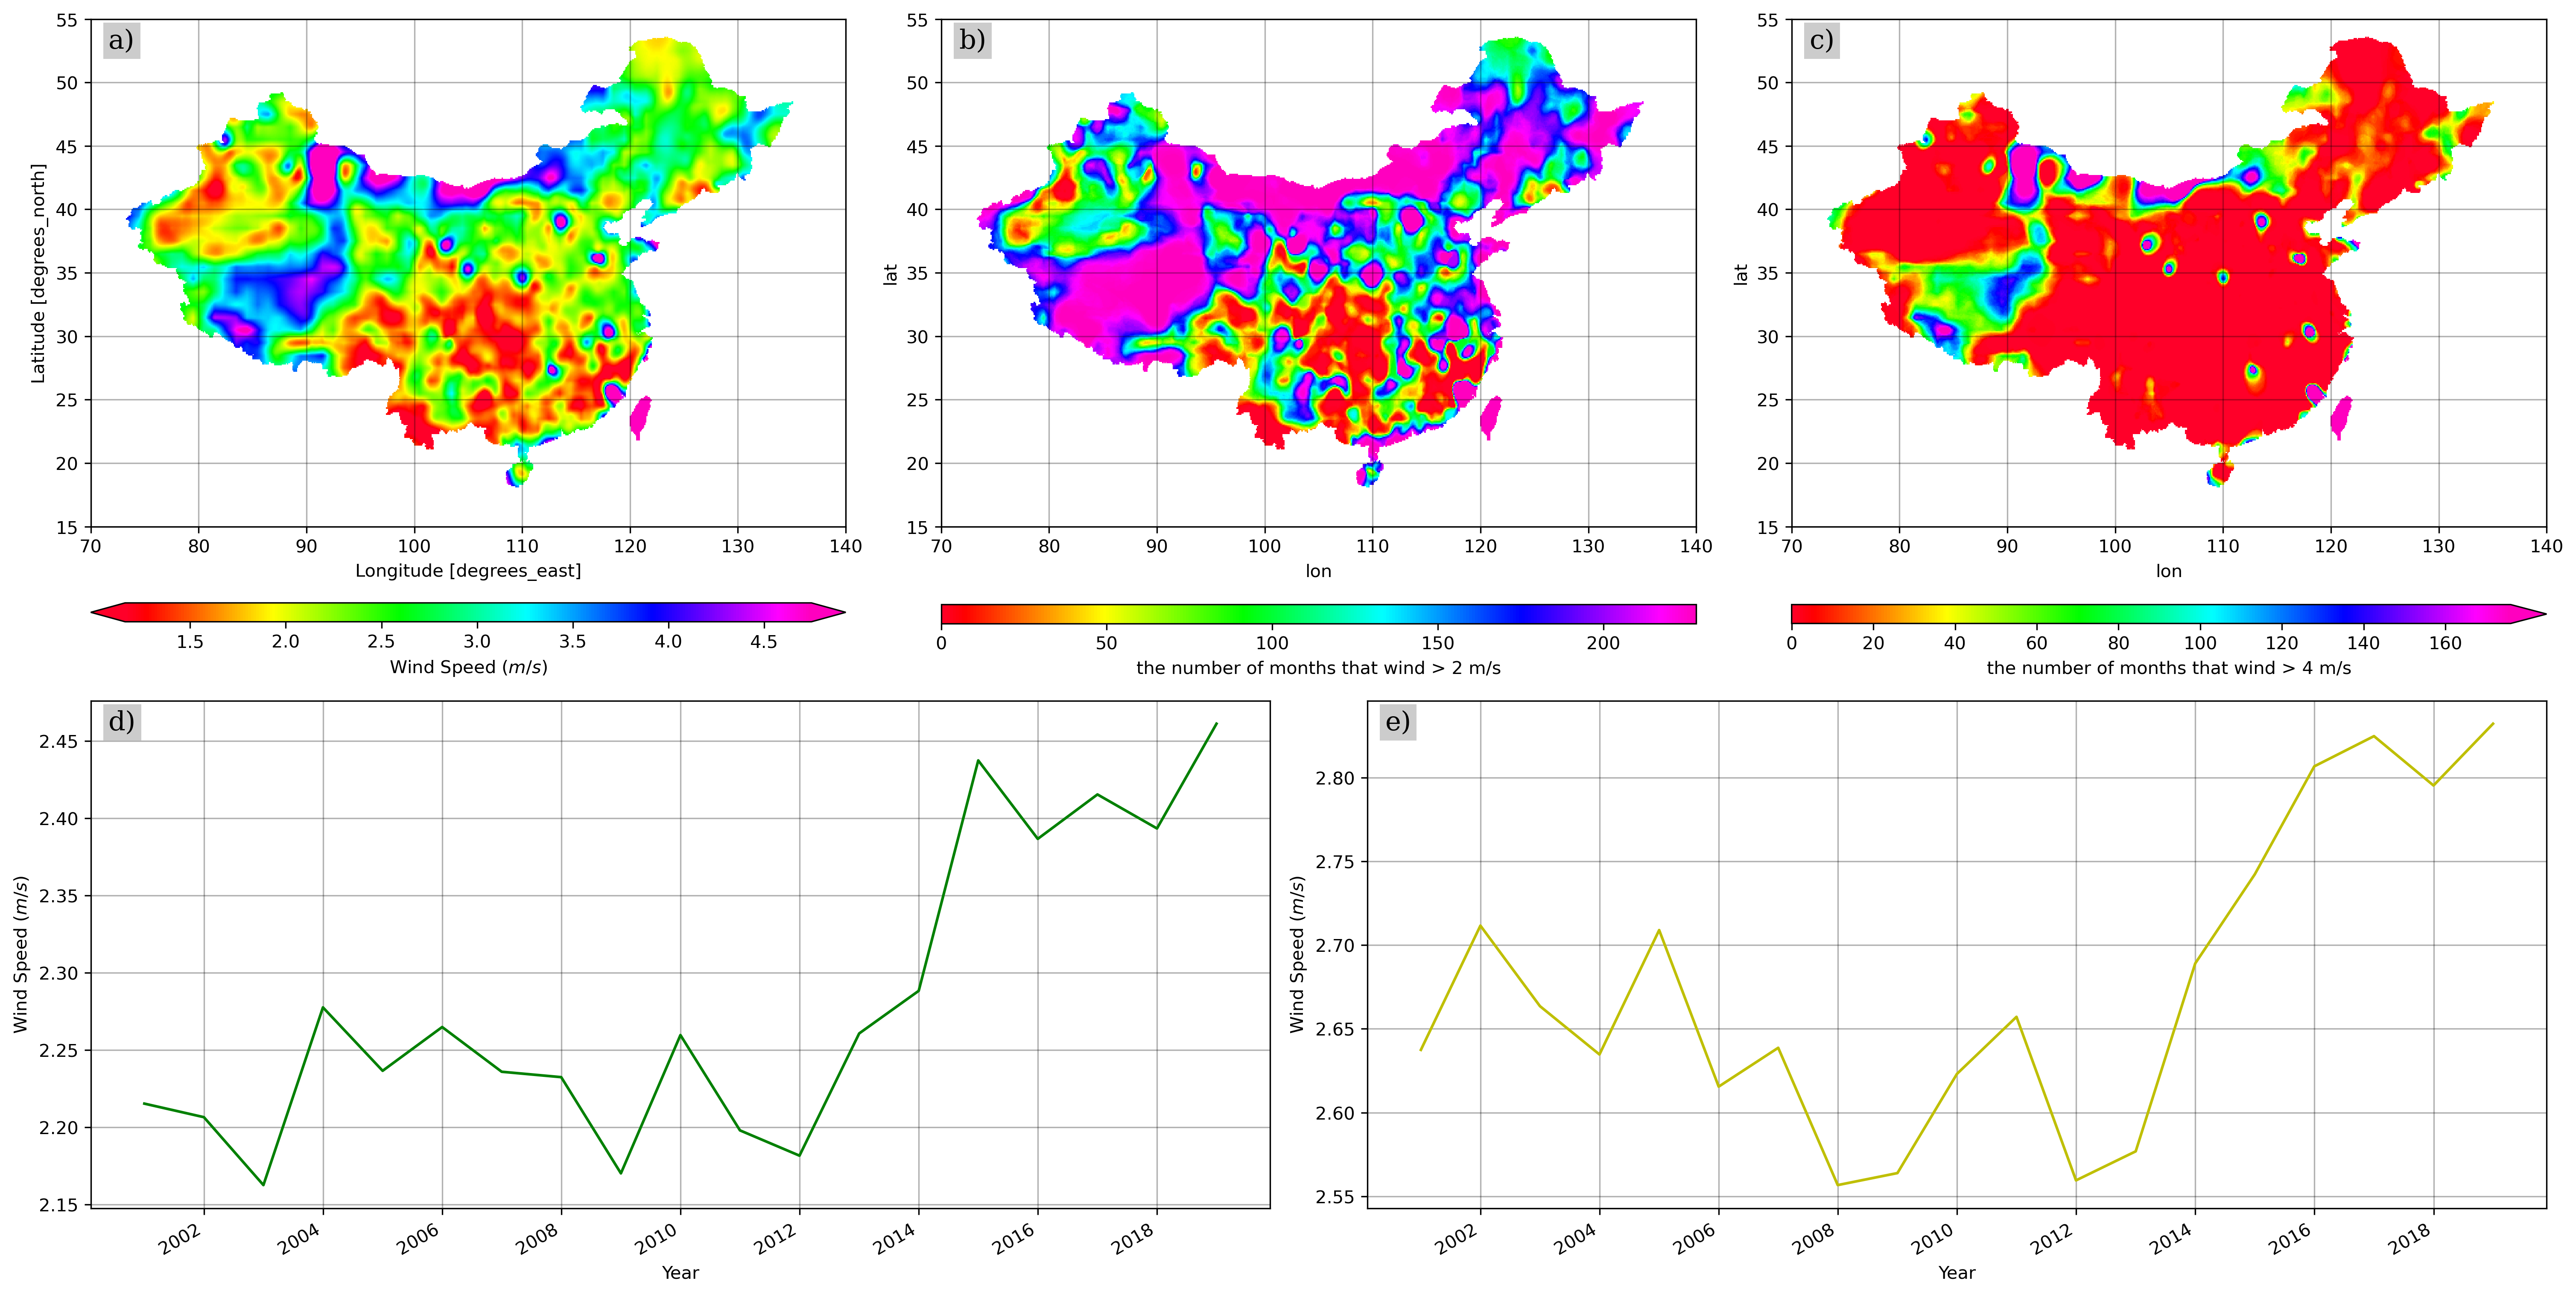

In [42]:
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['a)','a)', 'b)', 'b)','c)','c)'], ['d)', 'd)','d)','e)', 'e)','e)']],
                              constrained_layout=True,figsize=(20,10))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=3.0))

ds_wind['wind'].mean(dim='time').plot(ax=axs['a)'],robust=True,cbar_kwargs={'location':'bottom','label':'Wind Speed $(m/s)$'},cmap='gist_rainbow')
axs['a)'].grid(c='k',lw=0.8,alpha=0.3)
da_windle2.plot(ax=axs['b)'],robust=True,cbar_kwargs={'location':'bottom','label':'the number of months that wind > 2 m/s'},cmap='gist_rainbow')
axs['b)'].grid(c='k',lw=0.8,alpha=0.3)
da_windle4.plot(ax=axs['c)'],robust=True,cbar_kwargs={'location':'bottom','label':'the number of months that wind > 4 m/s'},cmap='gist_rainbow')
axs['c)'].grid(c='k',lw=0.8,alpha=0.3)
ds_wind['wind'].resample(time='y').mean(skipna=False).sel(lat=slice(15,35)).mean(dim={'lon','lat'}).plot(ax=axs['d)'],c='g')
axs['d)'].grid(c='k',lw=0.8,alpha=0.3)
axs['d)'].set_xlabel('Year')
axs['d)'].set_ylabel('Wind Speed $(m/s)$')
ds_wind['wind'].resample(time='y').mean(skipna=False).sel(lat=slice(35,55)).mean(dim={'lon','lat'}).plot(ax=axs['e)'],c='y')
axs['e)'].grid(c='k',lw=0.8,alpha=0.3)
axs['e)'].set_xlabel('Year')
axs['e)'].set_ylabel('Wind Speed $(m/s)$')

plt.show()